In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler

import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.io import read_image

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time

from PIL import Image
import os
import cv2
import numpy as np

In [2]:
COLOR_PATH_TRAIN = "/data/fd2135/imagenet/ILSVRC/Data/DET/train/ILSVRC2013_train/n01530575"
SKETCH_PATH_TRAIN = "/data/fd2135/imagenet/ILSVRC/Data/DET/train/ILSVRC2013_train_sketch/n01530575"
COLOR_PATH_TEST = "/data/fd2135/imagenet/ILSVRC/Data/DET/test/test"
SKETCH_PATH_TEST = "/data/fd2135/imagenet/ILSVRC/Data/DET/test/test_sketch"
COLOR_PATH_VAL = "/data/fd2135/imagenet/ILSVRC/Data/DET/test/val"
SKETCH_PATH_VAL = "/data/fd2135/imagenet/ILSVRC/Data/DET/test/val_sketch"

In [3]:
from torchvision.io.image import ImageReadMode
from torchvision.transforms.functional import resize
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize

resizer=Resize([256,256])

class CustomImageDataset(Dataset):
    def __init__(self, sketch_dir, color_dir, transform=None, target_transform=None):
        self.sketch_dir = sketch_dir
        self.color_dir = color_dir
        self.transform = transform
        self.target_transform = target_transform
        self.dirs=os.listdir(sketch_dir)

    def __len__(self):
        return len(self.dirs)
        #return 1000

    def __getitem__(self, idx):
        file_name=self.dirs[idx]
        sketch_path = os.path.join(self.sketch_dir, file_name)
        sketch_image = read_image(sketch_path, ImageReadMode.GRAY)
        sketch_image=resizer(sketch_image)

        color_path = os.path.join(self.color_dir, file_name)
        color_image = read_image(color_path, ImageReadMode.RGB)
        color_image=resizer(color_image)

        if self.transform:
            sketch_image = self.transform(sketch_image)
        if self.target_transform:
            color_image = self.target_transform(color_image)
        return sketch_image, color_image

In [4]:
training_data = CustomImageDataset(
    SKETCH_PATH_TRAIN,
    COLOR_PATH_TRAIN,
    transform=None,
    target_transform=None
)
test_data = CustomImageDataset(
    SKETCH_PATH_TEST,
    COLOR_PATH_TEST,
    transform=None,
    target_transform=None
)
val_data = CustomImageDataset(
    SKETCH_PATH_VAL,
    COLOR_PATH_VAL,
    transform=None,
    target_transform=None
)

In [5]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)
val_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

Sketch image shape: torch.Size([64, 1, 256, 256])
Colorful image shape: torch.Size([64, 3, 256, 256])


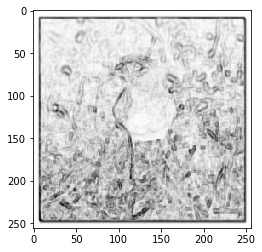

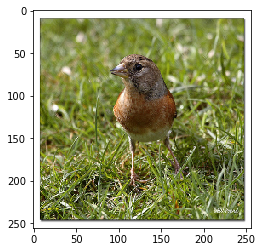

In [6]:
train_sketch, train_color = next(iter(train_dataloader))
print(f"Sketch image shape: {train_sketch.size()}")
print(f"Colorful image shape: {train_color.size()}")
img_s = train_sketch[15].squeeze()
img_c = train_color[15]
plt.imshow(img_s, cmap="gray")
plt.show()
img_c=np.swapaxes(img_c,0,1)
img_c=np.swapaxes(img_c,1,2)
plt.imshow(img_c)
plt.show()

In [7]:
import torch
from torch import nn

class BaseColor(nn.Module):
    def __init__(self):
        super(BaseColor, self).__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.

    def normalize_l(self, in_l):
        return (in_l-self.l_cent)/self.l_norm

    def unnormalize_l(self, in_l):
        return in_l*self.l_norm + self.l_cent

    def normalize_ab(self, in_ab):
        return in_ab/self.ab_norm

    def unnormalize_ab(self, in_ab):
        return in_ab*self.ab_norm

In [8]:
import torch
import torch.nn as nn
import numpy as np
from IPython import embed

class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 3, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')
        

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))
        

        return self.unnormalize_ab(self.upsample4(out_reg))

In [9]:
model=ECCVGenerator()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

In [10]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    model.train()
    for (x, y) in iterator:
            
        print(x.size())
        print(y.size())
        
        x_data = torch.tensor(x, dtype=torch.float32)/255
        y_data = torch.tensor(y, dtype=torch.float32)/255
        
        optimizer.zero_grad()
                
        y_pred = model(x_data)
        loss = criterion(y_pred, y_data)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [11]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    
    model.eval()
    with torch.no_grad():
        
        for (x, y) in iterator:
            
            
            x_data = torch.tensor(x, dtype=torch.float32)/255
            y_data = torch.tensor(y, dtype=torch.float32)/255
            
            

            y_pred = model(x_data)

            loss = criterion(y_pred, y_data)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [13]:
BATCH_SIZE = 256
train_iterator = train_dataloader

EPOCHS = 5

best_loss=1000
best_epoch=0

overall_train_loss=[]
#overall_val_loss=[]

for epoch in range(EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, device)
    #val_loss = evaluate(model, valid_iterator, criterion, device)
    print('Epoch %s, Train loss %s'%(epoch, train_loss))
    
    overall_train_loss.append(train_loss)
    #overall_val_loss.append(val_loss.item())
    
    if best_loss>train_loss:
        best_loss=train_loss
        best_epoch=epoch
        
    torch.save(model,'net_{}.pth'.format(epoch))
    
print('Best epoch number is %s'%(best_epoch))

torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])


<ipython-input-10-706acf5ef698>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x, dtype=torch.float32)/255
<ipython-input-10-706acf5ef698>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y, dtype=torch.float32)/255


torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 0, Train loss 0.06130826739328248
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 1, Train loss 0.05878550931811333
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 2

In [14]:
EPOCHS = 5

best_epoch=0

for epoch in range(EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, device)
    #val_loss = evaluate(model, valid_iterator, criterion, device)
    print('Epoch %s, Train loss %s'%(epoch+5, train_loss))
    
    overall_train_loss.append(train_loss)
    #overall_val_loss.append(val_loss.item())
    
    if best_loss>train_loss:
        best_loss=train_loss
        best_epoch=epoch+5
        
    torch.save(model,'net_{}.pth'.format(epoch+5))
    
print('Best epoch number is %s'%(best_epoch+5))

torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])


<ipython-input-10-706acf5ef698>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x, dtype=torch.float32)/255
<ipython-input-10-706acf5ef698>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y, dtype=torch.float32)/255


torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 5, Train loss 0.05769253149628639
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 6, Train loss 0.05759462394884655
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 2

In [15]:
EPOCHS = 5

best_epoch=0

for epoch in range(EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, device)
    #val_loss = evaluate(model, valid_iterator, criterion, device)
    print('Epoch %s, Train loss %s'%(epoch+10, train_loss))
    
    overall_train_loss.append(train_loss)
    #overall_val_loss.append(val_loss.item())
    
    if best_loss>train_loss:
        best_loss=train_loss
        best_epoch=epoch+10
        
    torch.save(model,'net_{}.pth'.format(epoch+10))
    
print('Best epoch number is %s'%(best_epoch))

torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])


<ipython-input-10-706acf5ef698>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x, dtype=torch.float32)/255
<ipython-input-10-706acf5ef698>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y, dtype=torch.float32)/255


torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 10, Train loss 0.05748424625822476
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 11, Train loss 0.05722596602780478
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1,

In [16]:
EPOCHS = 5

best_epoch=0

for epoch in range(EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, device)
    #val_loss = evaluate(model, valid_iterator, criterion, device)
    print('Epoch %s, Train loss %s'%(epoch+15, train_loss))
    
    overall_train_loss.append(train_loss)
    #overall_val_loss.append(val_loss.item())
    
    if best_loss>train_loss:
        best_loss=train_loss
        best_epoch=epoch+15
        
    torch.save(model,'net_{}.pth'.format(epoch+15))
    
print('Best epoch number is %s'%(best_epoch))

torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])


<ipython-input-10-706acf5ef698>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x, dtype=torch.float32)/255
<ipython-input-10-706acf5ef698>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y, dtype=torch.float32)/255


torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 15, Train loss 0.05669489290033068
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 16, Train loss 0.05613299831748009
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1,

In [17]:
EPOCHS = 5

best_epoch=0

for epoch in range(EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, device)
    #val_loss = evaluate(model, valid_iterator, criterion, device)
    print('Epoch %s, Train loss %s'%(epoch+20, train_loss))
    
    overall_train_loss.append(train_loss)
    #overall_val_loss.append(val_loss.item())
    
    if best_loss>train_loss:
        best_loss=train_loss
        best_epoch=epoch+20
        
    torch.save(model,'net_{}.pth'.format(epoch+20))
    
print('Best epoch number is %s'%(best_epoch))

torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])


<ipython-input-10-706acf5ef698>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x, dtype=torch.float32)/255
<ipython-input-10-706acf5ef698>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y, dtype=torch.float32)/255


torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 20, Train loss 0.05516352717365537
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 21, Train loss 0.05452257181916918
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1,

In [18]:
EPOCHS = 5

best_epoch=0

for epoch in range(EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, device)
    #val_loss = evaluate(model, valid_iterator, criterion, device)
    print('Epoch %s, Train loss %s'%(epoch+25, train_loss))
    
    overall_train_loss.append(train_loss)
    #overall_val_loss.append(val_loss.item())
    
    if best_loss>train_loss:
        best_loss=train_loss
        best_epoch=epoch+25
        
    torch.save(model,'net_{}.pth'.format(epoch+25))
    
print('Best epoch number is %s'%(best_epoch))

torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])


<ipython-input-10-706acf5ef698>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x, dtype=torch.float32)/255
<ipython-input-10-706acf5ef698>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y, dtype=torch.float32)/255


torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 25, Train loss 0.053572079432862144
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 26, Train loss 0.05423801764845848
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1

In [19]:
EPOCHS = 5

best_epoch=0

for epoch in range(EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, device)
    #val_loss = evaluate(model, valid_iterator, criterion, device)
    print('Epoch %s, Train loss %s'%(epoch+30, train_loss))
    
    overall_train_loss.append(train_loss)
    #overall_val_loss.append(val_loss.item())
    
    if best_loss>train_loss:
        best_loss=train_loss
        best_epoch=epoch+30
        
    torch.save(model,'net_{}.pth'.format(epoch+30))
    
print('Best epoch number is %s'%(best_epoch))

torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])


<ipython-input-10-706acf5ef698>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x, dtype=torch.float32)/255
<ipython-input-10-706acf5ef698>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y, dtype=torch.float32)/255


torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 30, Train loss 0.05310875656349318
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([46, 3, 256, 256])
Epoch 31, Train loss 0.05310154493365969
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 1,

In [20]:
print(overall_train_loss)

[0.06130826739328248, 0.05878550931811333, 0.058042136686188836, 0.05788878085357802, 0.05775775547538485, 0.05769253149628639, 0.05759462394884655, 0.057482990835394175, 0.05711889373404639, 0.05799899782453265, 0.05748424625822476, 0.05722596602780478, 0.05681577484522547, 0.056430380259241374, 0.056600945868662426, 0.05669489290033068, 0.05613299831748009, 0.055960189018930705, 0.05518950309072222, 0.05511595894183431, 0.05516352717365537, 0.05452257181916918, 0.0544930100440979, 0.05413396709731647, 0.05407737727676119, 0.053572079432862144, 0.05423801764845848, 0.05440731878791537, 0.053927965994392126, 0.05329333032880511, 0.05310875656349318, 0.05310154493365969, 0.054002326514039724, 0.05314232941184725, 0.05310781353286335]


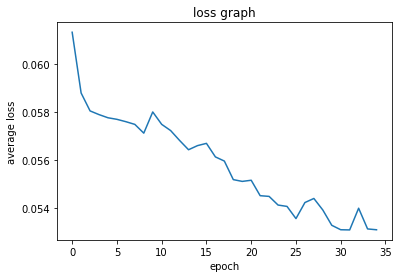

In [21]:
plt.plot(overall_train_loss)
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.title('loss graph')
plt.show()